### 05-2 교차 검증과 그리드 서치
#### *Keyword : 검증세트, 교차검증, 그리드 서치, 랜덤 서치
#### *핵심포인트 
#### - 검증세트: 하이퍼파라미터 튜닝을 위해 모델을 평가할때, 훈련세트에서 떼어낸 데이터 세트
#### - 교차검증: 훈련세트를 여러 폴드로 나눈 다음 한 폴드가 검증 세트이 역할을 하고 나머지 폴드는 모델을 훈련, 모든 폴드에 대한 검증 점수의 평균
#### - 그리드서치: 하이퍼파라미터 탐색 자동화 도구
#### - 랜덤서치: 연속된 매개변수 값을 탐색할 때 유용. 탐색 값을 샘플링 할 수 있는 확률 분포 객체를 전달 , 지정된 횟수만큼 샘플링
#### *핵심패키지와 함수 
#### - cross-validate(): 교차검증 수행 함수
#### - GridSearchCV(): 하이퍼파라미터 탐색
#### - RandomizedSearchCV : 랜덤한 하이퍼파라미터 탐색


In [ ]:
# 검증세트 : validation Set (테스트 세트를 사용하지 않고 훈련세트를 나눠서 검증세트로 제작)
# 훈련세트로 모델을 훈련하고 검증 세트로 모델을 평가

import pandas as pd
wine = pd.read_csv('http://bit.ly/wine_csv_data')

In [2]:
data = wine[['alcohol','sugar','pH']]
target = wine['class']

In [3]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target= train_test_split(
    data, target, test_size=0.2, random_state=42)

In [ ]:
# 훈련세트를 서브훈련세트와 검증세트로 나누기, 비율을 20%로 설정하여 훈련세트의 20%을 검증세트로 설정
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [6]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [ ]:
#서브훈련세트와 검증세트로 결정트리모델검증

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

# 서브훈련세트 점수 > 검증세트 : 과대적합 -> 매개변수 바꿔서 더 좋은 모델 찾기

0.9971133028626413
0.8634615384615385


### 교차검증
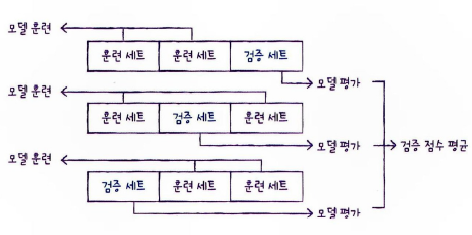
#### - 3-fold cross validation : 훈련세트를 세 부분으로 나눠서 교차 검증 수행
#### - 일반적으로 5-fold, 10-fold cross validation을 많이 씀 : 데이터의 80-90%까지 훈련에 사용

In [ ]:
# 교차검증(cross validation)

from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)

# fit-time, score-time, test_score의 키를 가진 dictionary 반환
# fit-time : 모델 훈련 시간
# score-time: 모델 검증 시간
# cross_validate(): 기본적으로 5-fold cross validate 수행, cv 매개변수로 fold 수 변경가능

{'fit_time': array([0.0090425 , 0.00891328, 0.00768304, 0.00686407, 0.00622821]), 'score_time': array([0.00217319, 0.00197792, 0.00169873, 0.00137877, 0.00138569]), 'test_score': array([0.86923077, 0.85      , 0.87584216, 0.85659288, 0.84119346])}


In [9]:
# 교차검증의 최종점수는 test_score의 평균값
import numpy as np
print(np.mean(scores['test_score']))

0.858571851632487


In [ ]:
# 우리는 앞에서 train_test_split()으로 전체데이터를 섞은 후 훈련 세트 준비, 따로 섞을 필요가 없었음
# 하지만, cross_validate()는 훈련 세트를 섞어서 데이터를 나누지 않음
# 훈련세트를 섞으려면 splitter 지정
# 회귀 모델일 경우 KFolf splitter을 사용
# 분류 모델일 경우 StratifiedKFold 사용

from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv= StratifiedKFold())
print(np.mean(scores['test_score']))

0.856647664174132


In [ ]:
# 훈련세트를 섞은 후 10-fold cross validation 진행 

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target,cv=splitter)
print(np.mean(scores['test_score']))

0.8572283978064326


In [ ]:
# 하이퍼파라미터 튜닝
# 모델 파라미터 : 머신러닝 모델이 학습하는 파라미터 
# 하이퍼파라미터 : 모델이 학습 할 수 없어서 사용자가 지정하야하만 하는 파라미터
# 그리드 서치(Grid Search): 하이퍼파라미터 탐색과 교차 검증을 한번에 수행 

# GridSearchCV를 import하고 매개변수와 탐색할 값의 리스트를 딕셔너리로
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [ ]:
# gs 객체 생성 = GridSearchCV에 탐색대상모델과 params변수를 전달
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs = -1)

In [ ]:
# GridSearchCV의 cv 매개변수 기본값은 5 
# min_impurity_decrease 값마다 5-fold cross validation 수행 
# n_jobs = -1 : 병렬 실행에 사용할 CPU 코어 수 지정  (-1이면 시스템에 있는 모든 코어 사용)

gs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'min_impurity_decrease': [0.0001, 0.0002, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [ ]:
# 교차 검증 점수가 가장 높은 모델의 매개변수 조합으로 전체 훈련 세트에서 자동으로 다시 모델 훈련
# 모델은 gs 객체의 best_estimator_속성에 저장되어 있음
# 이 모델을 일반 결정트리 처럼 똑같이 사용

dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [ ]:
# 그리드서치로 찾은 최적의 매개변수는 best_params_ 속성에 저장됨
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [ ]:
# 각 매개변수에서 수행한 교차 검증이 평균 점수는 cv_results_ 속성에 저장

print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [ ]:
# best_index_ 속성을 사용해 가장 높은 값의 인덱스를 얻을 수 있음

print(gs.cv_results_['params'][gs.best_index_])

{'min_impurity_decrease': 0.0001}


In [ ]:
# 복잡한 매개변수 조합 탐색
# min_impurity_decrease : 노드를 분할하기 위한 불순도 감소 최소량 지정
# max_depth: 트리의 깊이 제한
# min_samples_split: 노드를 나누기 위한 최소 샘플 수 

params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2,100,10)}

# 첫번째 매개변수 값에서 시작해서 두번째 매개변수에 도달할때까지 세 번째 매개변수를 더한 배열을 생성 ex) 0.0001에 시작하여 0.001이 될때까지 0.0001씩 더한 배열, 0.0001~0.0009까지 원소는 총 9개 
# 5에서 1씩 증가해서 20 까지 
# 2에서 10씩 증가해서 100까지 
# 최종 교차 검증 횟수 = 9*15*10=1,350, 기본 5-fold -> 최종 생성 모델 수 = 6,750 

In [28]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs = -1)
gs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': range(5, 20), 'min_impurity_decrease': array([0.0001... 0.0009]), 'min_samples_split': range(2, 100, 10)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [30]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': np.float64(0.0004), 'min_samples_split': 12}


In [31]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


#### 랜덤서치
#### - 매개변수의 값이 수치일 떄나 값의 범위나 간격을 미리 정하기 어려울 때
#### - 너무 많은 매개변수 조건이 있어 그리드 서치 수행 시간이 오래 걸릴 때
#### - 매개변수 값의 목록을 전달하는게 아니라 매개변수를 샘플링할 수 있는 확률 분포 객체를 전달

In [ ]:
# stats 서브 패키지에 있는 uniform(실수값)과 randint(정수값) 클래스는 주어진 범위에서 고르게 값을 뽑음 -> '균등 분포에서 샘플링'

from scipy.stats import uniform, randint


In [38]:
# 0 ~ 10 사이의 범위를 갖는 객체를 만들고 10개의 숫자를 샘플링

rgen = randint (0,10)
rgen.rvs(10)

array([0, 0, 7, 3, 9, 6, 4, 9, 3, 8])

In [39]:
#1000개를 샘플링해서 각 숫자의 개수를 확인
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 94, 100,  80,  87, 108, 126,  96, 108, 106,  95]))

In [41]:
ugen = uniform(0,1)
ugen.rvs(10)

array([0.4967692 , 0.37278471, 0.61869374, 0.53351396, 0.60675485,
       0.28995848, 0.42390287, 0.12242476, 0.48361936, 0.41604844])

In [44]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20,50),
          'min_samples_split': randint(2,25),
          'min_samples_leaf': randint(1,25)}

In [ ]:
#랜덤으로 지정된 매개변수 범위에서, n_iter =100(총100번)을 샘플링하여 교차 검증 수행하여 최적의 매개변수 조합 찾기
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),params,
                        n_iter=100, n_jobs = -1, random_state=42)
rs.fit (train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....x7fe9d77988e0>, 'min_impurity_decrease': <scipy.stats....x7fe9d200b700>, 'min_samples_leaf': <scipy.stats....x7fe9e16d96f0>, 'min_samples_split': <scipy.stats....x7fe9d200b4f0>}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [46]:
print(rs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': np.float64(0.00034102546602601173), 'min_samples_leaf': 7, 'min_samples_split': 13}


In [47]:
print(np.max(rs.cv_results_['mean_test_score']))

0.8695428296438884


In [ ]:
# 최종모델을 결정하고 테스트 세트의 성능확인

dt = rs.best_estimator_
print(dt.score(test_input, test_target))

0.86
